# Toy Experiments

In [1]:
import os, sys
sys.path.append("..")

from src import distributions

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from basic import ScoreNetwork

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

from src.plotters import plot_trajectories

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
X_sampler = distributions.StandardNormalSampler(dim=2, device="cuda")
Y_sampler = distributions.SwissRollSampler(device="cuda")
# Y_sampler = distributions.Mix8GaussiansSampler(std=0.1, r=np.sqrt(2), device="cuda")

DIM = 2
H = 100

batch_size = 1000
lr = 1e-4
n_steps = 100
GAMMA = 0.0
G_ITERS = 5
D_ITERS = 1
f_ITERS = 2
MAX_STEPS = 30000


ZC = 1
Z_STD = 1.0

In [3]:
def train(X_sampler, Y_sampler, f, f_opt, G, G_opt, D, D_opt, sde, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):

        for G_iter in range(G_ITERS):

            for f_iter in range(f_ITERS):
                x0 = X_sampler.sample(batch_size)
                Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
                xN = G(torch.cat([x0, Z], axis = -1))
                
                t = (torch.rand(x0.shape[0])[:, None]*0.995).cuda()
                xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
                f_loss = ((f(xt, t) - (xN - xt)/(1-t)) ** 2).mean()
                f_opt.zero_grad(); f_loss.backward(); f_opt.step()

            x0 = X_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))

            t = (torch.rand(x0.shape[0])[:, None]*0.995).cuda()
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            f_x_t = f(xt, t)
            E = (xN - xt)/(1-t)
            
            loss1 = ((f_x_t*E).mean() - (f_x_t*f_x_t).mean()/2)*2
            loss2 = -D(xN).mean()
            
            G_loss = loss1 + loss2
            
            
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()
        
        print(loss1.item(), loss2.item())
        
        # plotter 1
        if step % 500 == 0:
            clear_output(wait=True)
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            X = X_sampler.sample(plot_n_samples)
            
            Z = torch.randn(plot_n_samples, ZC, device='cuda') * Z_STD
            G_dataset = G(torch.cat([X, Z], axis = -1)).detach().cpu()
            f_dataset = sde(X).detach().cpu()

            G_mse.append(F.mse_loss(X.detach().cpu(), G_dataset).item())
            sde_mse.append(F.mse_loss(X.detach().cpu(), f_dataset).item())
            print('G mse:', G_mse[-1])
            print('sde mse:', sde_mse[-1])


            with torch.no_grad():
                X = X_sampler.sample(10000)

                T_XZ_np = []
                
                # Our method results G
                for i in range(100):
                    Z = torch.randn(10000, ZC, device='cuda') * Z_STD
                    T_XZ_np.append(G(torch.cat([X, Z], axis = -1)).cpu().numpy())
            
                T_XZ_np = np.array(T_XZ_np)
                G_var.append(T_XZ_np.var(axis=0).mean(axis=0).mean().item())
                print('G var:', G_var[-1])

                T_X_np = []
                for i in range(100):
                    T_X_np.append(sde(X).cpu().numpy())
            
                T_X_np = np.array(T_X_np)
                sde_var.append(T_X_np.var(axis=0).mean(axis=0).mean().item())
                print('sde var:', sde_var[-1])
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()
            
        for D_iter in range(D_ITERS):    
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var, sde_mse, sde_var)

## 4. Training

In [4]:
f = ScoreNetwork().cuda()

G = nn.Sequential(
    nn.Linear(DIM+ZC, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM),
).cuda()


D = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1),
).cuda()


f_opt = Adam(f.parameters(), lr=lr)
G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr/10)


class SDE(nn.Module):
    def __init__(self, shift_model, n_steps):
        super().__init__()
        self.shift_model = shift_model
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
    
    def forward(self, x0, traj = False):
        x, t = x0, 0.0
        trajectory = [x]
        for step in range(self.n_steps):
            batch_size = x.shape[0]
            if step < n_steps - 5:
                x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda()) + torch.randn_like(x)*np.sqrt(GAMMA*self.delta_t)
            else:
                x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda())
            t += self.delta_t
            trajectory.append(x)
        if traj:
            return x, trajectory
        return x
    

G mse: 0.15161877870559692
sde mse: 0.15062041580677032
G var: 0.0018354363273829222
sde var: 4.397729738963435e-13


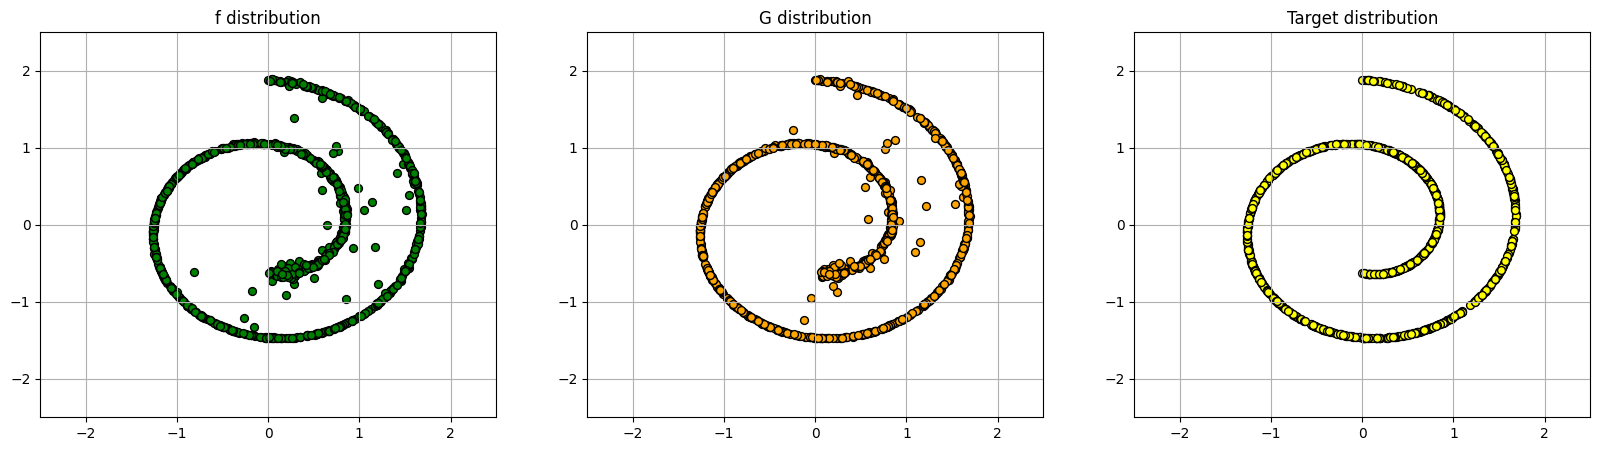

0.15710854530334473 0.06537056714296341


 98%|█████████▊| 29508/30000 [16:44<01:50,  4.44it/s]

0.14290177822113037 0.06535857170820236
0.15921060740947723 0.0670243576169014
0.15846046805381775 0.06404171139001846
0.1612910032272339 0.06331796199083328
0.1524728536605835 0.05383209511637688
0.14862596988677979 0.05882597342133522
0.1548020988702774 0.0727030485868454
0.15573257207870483 0.05621372163295746
0.15734374523162842 0.06190291792154312


 98%|█████████▊| 29518/30000 [16:45<00:59,  8.15it/s]

0.15754787623882294 0.06332801282405853
0.15877346694469452 0.06510890275239944
0.1543966829776764 0.06580733507871628
0.15539781749248505 0.05778142064809799
0.14829587936401367 0.06416776031255722
0.15214398503303528 0.07151439040899277
0.16210508346557617 0.0637378916144371
0.15485212206840515 0.06324049085378647
0.1526298075914383 0.06590218096971512


 98%|█████████▊| 29528/30000 [16:45<00:34, 13.79it/s]

0.16489900648593903 0.06935679912567139
0.16166771948337555 0.07271397858858109
0.15193991363048553 0.05062764137983322
0.14982908964157104 0.07066105306148529
0.1591394543647766 0.06737612932920456
0.1477964222431183 0.07057533413171768
0.14408497512340546 0.05434395745396614
0.15437649190425873 0.060189004987478256
0.14044299721717834 0.055972468107938766


 98%|█████████▊| 29533/30000 [16:45<00:27, 17.20it/s]

0.15858633816242218 0.06186944618821144
0.1472974717617035 0.07473398000001907
0.15268436074256897 0.06587646901607513
0.15388745069503784 0.07179366797208786
0.15821556746959686 0.05196581408381462
0.1476810872554779 0.07171984761953354
0.15366564691066742 0.06506466865539551
0.15659061074256897 0.06466936320066452


 98%|█████████▊| 29538/30000 [16:45<00:22, 20.84it/s]

0.17430688440799713 0.0625770166516304


 98%|█████████▊| 29543/30000 [16:45<00:18, 24.10it/s]

0.1595916897058487 0.05463162437081337
0.14733090996742249 0.07061950862407684
0.1529332995414734 0.0720607340335846
0.1657288372516632 0.06142294406890869
0.15383656322956085 0.054568223655223846
0.17143751680850983 0.07243368774652481
0.16259056329727173 0.06165182963013649
0.1450842022895813 0.059250012040138245


 99%|█████████▊| 29553/30000 [16:45<00:14, 30.74it/s]

0.16129173338413239 0.05751854181289673
0.14974866807460785 0.06396527588367462
0.16202285885810852 0.0633934959769249
0.14524602890014648 0.06578314304351807
0.16533640027046204 0.0662405863404274
0.1548824906349182 0.05767672136425972
0.15426097810268402 0.06521749496459961
0.15931691229343414 0.05795015022158623
0.15540553629398346 0.0729430541396141


 99%|█████████▊| 29563/30000 [16:46<00:12, 35.56it/s]

0.14972348511219025 0.04993380233645439
0.15293388068675995 0.05884822458028793
0.15053798258304596 0.06210998445749283
0.1504179835319519 0.06300149857997894
0.14615119993686676 0.06074053421616554
0.1524076759815216 0.064000703394413
0.16062436997890472 0.043945275247097015
0.15146450698375702 0.07105883210897446
0.14883121848106384 0.06497892737388611


 99%|█████████▊| 29568/30000 [16:46<00:11, 37.12it/s]

0.15118877589702606 0.04971476271748543
0.1609693020582199 0.07760093361139297
0.14550113677978516 0.06164349988102913
0.15790043771266937 0.0594748891890049
0.1432974636554718 0.05766236409544945
0.14520953595638275 0.08703860640525818
0.14873971045017242 0.05682756379246712
0.16143934428691864 0.060284968465566635


 99%|█████████▊| 29573/30000 [16:46<00:11, 38.40it/s]

0.15198500454425812 0.07270295172929764


 99%|█████████▊| 29578/30000 [16:46<00:10, 39.38it/s]

0.15188467502593994 0.06928851455450058
0.14755181968212128 0.07283876091241837
0.15016703307628632 0.07220177352428436
0.14499418437480927 0.06874202191829681
0.14339609444141388 0.07969330251216888
0.166896790266037 0.06382235884666443
0.1551690399646759 0.06463991105556488
0.1528017371892929 0.07343477755784988
0.1537908911705017 0.05846573784947395


 99%|█████████▊| 29588/30000 [16:46<00:10, 40.22it/s]

0.14553751051425934 0.05576641112565994
0.15822084248065948 0.08118432015180588
0.14045295119285583 0.06791258603334427
0.1401575803756714 0.06880780309438705
0.14531850814819336 0.06288345158100128
0.146933451294899 0.058358460664749146
0.15580056607723236 0.05472284182906151
0.15274348855018616 0.07605563849210739
0.14137715101242065 0.07616807520389557


 99%|█████████▊| 29598/30000 [16:47<00:10, 39.25it/s]

0.15696096420288086 0.07024560123682022
0.14634042978286743 0.06263516843318939
0.1514783501625061 0.06224801018834114
0.15646734833717346 0.052009113132953644
0.15132743120193481 0.061532162129879
0.14820188283920288 0.07493897527456284
0.16678878664970398 0.06576117128133774
0.1571159064769745 0.06568361073732376


 99%|█████████▊| 29607/30000 [16:47<00:09, 40.26it/s]

0.14698484539985657 0.06710425019264221
0.15088869631290436 0.05861630663275719
0.1552285999059677 0.06248622387647629
0.1364685446023941 0.05548492446541786
0.15345734357833862 0.06219566985964775
0.1571144312620163 0.0705254077911377
0.15254899859428406 0.06378037482500076
0.14346380531787872 0.06913693249225616
0.15354132652282715 0.061610493808984756


 99%|█████████▊| 29612/30000 [16:47<00:09, 40.31it/s]

0.16843794286251068 0.05670151859521866
0.1569257527589798 0.06675595045089722
0.1558101326227188 0.0675956979393959
0.14648258686065674 0.06366562843322754
0.15847280621528625 0.06713207066059113
0.15041299164295197 0.05689740553498268
0.14312584698200226 0.06537099182605743
0.14003098011016846 0.06526623666286469


 99%|█████████▊| 29617/30000 [16:47<00:09, 40.57it/s]

0.15611134469509125 0.07373688369989395


 99%|█████████▊| 29622/30000 [16:47<00:09, 41.02it/s]

0.153300479054451 0.07059886306524277
0.16414524614810944 0.07431115955114365
0.16306902468204498 0.06565171480178833
0.1525523066520691 0.06387476623058319
0.1536310762166977 0.06484168022871017
0.16659367084503174 0.07499559968709946
0.13786354660987854 0.06352312117815018
0.1522396057844162 0.07486909627914429


 99%|█████████▉| 29632/30000 [16:47<00:09, 39.95it/s]

0.14336271584033966 0.06199127063155174
0.14843648672103882 0.07412886619567871
0.14950338006019592 0.07414775341749191
0.14741386473178864 0.07161570340394974
0.1475367546081543 0.06652142852544785
0.15688547492027283 0.07254978269338608
0.16769623756408691 0.08987144380807877
0.15635602176189423 0.08044704794883728
0.15930017828941345 0.07755501568317413


 99%|█████████▉| 29642/30000 [16:48<00:08, 41.01it/s]

0.1568206399679184 0.07285614311695099
0.14895173907279968 0.0699983686208725
0.14028477668762207 0.06813336163759232
0.14967797696590424 0.07635711133480072
0.14962346851825714 0.08076967298984528
0.14497074484825134 0.06405359506607056
0.1430768370628357 0.08152308315038681
0.14998000860214233 0.0738624706864357
0.15151873230934143 0.07105953991413116


 99%|█████████▉| 29647/30000 [16:48<00:08, 40.93it/s]

0.14797629415988922 0.062346432358026505
0.1460694968700409 0.062447525560855865
0.16183702647686005 0.08707015216350555
0.1466112583875656 0.06815773993730545
0.15537045896053314 0.0689719170331955
0.14935022592544556 0.07745150476694107
0.1563209891319275 0.07456564158201218
0.17043912410736084 0.056518957018852234


 99%|█████████▉| 29652/30000 [16:48<00:08, 40.91it/s]

0.1558118760585785 0.07716932892799377


 99%|█████████▉| 29657/30000 [16:48<00:08, 39.53it/s]

0.15249790251255035 0.06982377171516418
0.1638021171092987 0.08835215121507645
0.16057203710079193 0.07201509177684784
0.1570795327425003 0.06849196553230286
0.14861105382442474 0.060124557465314865
0.1506231427192688 0.06926494091749191
0.149809330701828 0.08707227557897568
0.15834540128707886 0.06635159254074097
0.16195690631866455 0.06303039193153381


 99%|█████████▉| 29667/30000 [16:48<00:08, 40.03it/s]

0.1559857577085495 0.08098369091749191
0.14688841998577118 0.06044944003224373
0.14710120856761932 0.07222270220518112
0.15783601999282837 0.07874704152345657
0.17192453145980835 0.07102158665657043
0.15610221028327942 0.060193948447704315
0.15880419313907623 0.07633817195892334
0.1425788253545761 0.0741884633898735
0.15317955613136292 0.06038996949791908


 99%|█████████▉| 29677/30000 [16:49<00:07, 40.86it/s]

0.14239493012428284 0.06587553769350052
0.1480056792497635 0.07719169557094574
0.14929623901844025 0.07526276260614395
0.1524503082036972 0.06005818396806717
0.15981559455394745 0.07045982778072357
0.15610982477664948 0.061100564897060394
0.1531793773174286 0.07295015454292297
0.152033269405365 0.07654763758182526
0.16161614656448364 0.04991883784532547


 99%|█████████▉| 29682/30000 [16:49<00:07, 40.86it/s]

0.15091873705387115 0.07200881093740463
0.15522386133670807 0.07363829761743546
0.15146394073963165 0.07485464215278625
0.15792593359947205 0.0711279958486557
0.14899952709674835 0.06226278096437454
0.15235276520252228 0.07291039079427719
0.15422146022319794 0.0873519629240036


 99%|█████████▉| 29687/30000 [16:49<00:07, 40.47it/s]

0.15411117672920227 0.06321094930171967
0.13719119131565094 0.07572802901268005


 99%|█████████▉| 29692/30000 [16:49<00:07, 40.32it/s]

0.1534159630537033 0.06690878421068192
0.14785408973693848 0.05613573268055916
0.14922171831130981 0.06883490085601807
0.16068901121616364 0.08144485950469971
0.16795629262924194 0.07199997454881668
0.14729376137256622 0.06972256302833557
0.16106046736240387 0.06831380724906921


 99%|█████████▉| 29697/30000 [16:49<00:07, 40.37it/s]

0.1629093587398529 0.05736155807971954
0.15272170305252075 0.0634404793381691


 99%|█████████▉| 29702/30000 [16:49<00:07, 40.62it/s]

0.15607784688472748 0.07214146852493286
0.1658954620361328 0.06594789773225784
0.16028860211372375 0.07811015844345093
0.16260084509849548 0.06583736091852188
0.16051556169986725 0.07128660380840302
0.15518426895141602 0.07387445122003555
0.16172339022159576 0.07112179696559906
0.1525280475616455 0.07140468806028366


 99%|█████████▉| 29711/30000 [16:49<00:07, 39.31it/s]

0.16516819596290588 0.07809631526470184
0.15174713730812073 0.07777951657772064
0.15283028781414032 0.08047448843717575
0.14413291215896606 0.057211898267269135
0.15946641564369202 0.06747686117887497
0.15965169668197632 0.06710949540138245
0.15943753719329834 0.07621365785598755
0.1559314876794815 0.07171913236379623


 99%|█████████▉| 29720/30000 [16:50<00:06, 40.01it/s]

0.14413057267665863 0.06022006273269653
0.15537352859973907 0.06301675736904144
0.1448998749256134 0.07266266644001007
0.1583128273487091 0.07238756120204926
0.16072344779968262 0.08197429031133652
0.14822238683700562 0.06115315854549408
0.14993642270565033 0.05948614701628685
0.16268694400787354 0.07266099750995636
0.15841460227966309 0.07066046446561813


 99%|█████████▉| 29730/30000 [16:50<00:06, 40.60it/s]

0.15175718069076538 0.05830945447087288
0.1374872326850891 0.0726298838853836
0.15615029633045197 0.07123041152954102
0.14848868548870087 0.050866931676864624
0.1547781080007553 0.07530860602855682
0.15784616768360138 0.05866803973913193
0.1545173078775406 0.05754230171442032
0.14809705317020416 0.057115424424409866
0.15285100042819977 0.07102736830711365


 99%|█████████▉| 29735/30000 [16:50<00:06, 40.98it/s]

0.15943679213523865 0.06806018203496933
0.16215364634990692 0.07116768509149551
0.16862936317920685 0.07630208134651184
0.14239802956581116 0.05104915052652359
0.17056463658809662 0.058049168437719345
0.15337148308753967 0.07237733155488968
0.14745841920375824 0.07846153527498245
0.15811286866664886 0.07068026810884476


 99%|█████████▉| 29740/30000 [16:50<00:06, 41.40it/s]

0.16034355759620667 0.07304909080266953


 99%|█████████▉| 29745/30000 [16:50<00:06, 41.56it/s]

0.13897842168807983 0.0801369771361351
0.1504756510257721 0.06791511178016663
0.15416395664215088 0.0669669359922409
0.1618156135082245 0.06948374956846237
0.14288336038589478 0.06710807234048843
0.15605278313159943 0.05651117116212845
0.16372965276241302 0.070623017847538
0.1387937217950821 0.07334330677986145
0.16106130182743073 0.05582566186785698


 99%|█████████▉| 29755/30000 [16:50<00:05, 41.70it/s]

0.15649084746837616 0.07642017304897308
0.14325758814811707 0.06942619383335114
0.15641812980175018 0.06725084036588669
0.15103031694889069 0.06365171074867249
0.1475314497947693 0.07008277624845505
0.14994709193706512 0.07563145458698273
0.15993541479110718 0.054221782833337784
0.15745258331298828 0.0649629533290863
0.16524949669837952 0.06718672811985016


 99%|█████████▉| 29765/30000 [16:51<00:05, 40.69it/s]

0.14205200970172882 0.06757715344429016
0.14580264687538147 0.056735552847385406
0.15143533051013947 0.061018381267786026
0.155604287981987 0.07040676474571228
0.14537689089775085 0.0637592226266861
0.1654728204011917 0.06559564918279648
0.15015216171741486 0.05869589373469353
0.16103585064411163 0.07577662914991379
0.1528693437576294 0.06405316293239594


 99%|█████████▉| 29770/30000 [16:51<00:05, 40.95it/s]

0.1643773913383484 0.058788400143384933
0.1534448117017746 0.059043336659669876
0.15939608216285706 0.06761004775762558
0.14878207445144653 0.04548493027687073
0.15758122503757477 0.0611175037920475
0.15603531897068024 0.06444510072469711
0.1488485038280487 0.04940401017665863


 99%|█████████▉| 29775/30000 [16:51<00:05, 41.69it/s]

0.1667395383119583 0.05746973678469658
0.14373502135276794 0.05108840391039848


 99%|█████████▉| 29780/30000 [16:51<00:05, 41.68it/s]

0.16956177353858948 0.04906943067908287
0.14984166622161865 0.06581372022628784
0.15411987900733948 0.07240352779626846
0.15247538685798645 0.058438606560230255
0.15132565796375275 0.06542936712503433
0.1584853231906891 0.06368844211101532
0.1459391713142395 0.04973612725734711


 99%|█████████▉| 29785/30000 [16:51<00:05, 41.76it/s]

0.15467426180839539 0.0541069470345974
0.14923177659511566 0.049265649169683456


 99%|█████████▉| 29790/30000 [16:51<00:05, 41.61it/s]

0.15520930290222168 0.05739050731062889
0.15678001940250397 0.05469872057437897
0.1470016986131668 0.05203895643353462
0.1553003489971161 0.0542789101600647
0.15034140646457672 0.06334659457206726
0.15664039552211761 0.05873601883649826
0.14677414298057556 0.06049016863107681
0.15610191226005554 0.04964655265212059
0.16625747084617615 0.06819421797990799


 99%|█████████▉| 29800/30000 [16:52<00:04, 41.49it/s]

0.1625794917345047 0.05169420689344406
0.1682087481021881 0.06316564232110977
0.15413635969161987 0.07091282308101654
0.1551445871591568 0.06870195269584656
0.15099671483039856 0.06335509568452835
0.15609528124332428 0.06836205720901489
0.15363965928554535 0.06935754418373108
0.14853423833847046 0.07085981965065002
0.169613778591156 0.06463702023029327


 99%|█████████▉| 29805/30000 [16:52<00:05, 38.62it/s]

0.14572809636592865 0.061017245054244995
0.15395458042621613 0.05898822471499443
0.16601823270320892 0.06780992448329926
0.1531798392534256 0.0632513016462326
0.1495583951473236 0.06898126751184464
0.1631409078836441 0.06008418649435043


 99%|█████████▉| 29810/30000 [16:52<00:04, 39.16it/s]

0.16344499588012695 0.05803331732749939
0.13989593088626862 0.07121720910072327


 99%|█████████▉| 29814/30000 [16:52<00:04, 39.36it/s]

0.16490192711353302 0.07073068618774414
0.15365564823150635 0.047659050673246384
0.16471774876117706 0.06584034860134125
0.1618882119655609 0.0617796890437603
0.16086553037166595 0.06305138766765594
0.14903920888900757 0.05697949603199959
0.14623790979385376 0.07038348913192749


 99%|█████████▉| 29819/30000 [16:52<00:04, 39.82it/s]

0.14878201484680176 0.062295105308294296
0.15352115035057068 0.06413434445858002


 99%|█████████▉| 29824/30000 [16:52<00:04, 40.24it/s]

0.15258775651454926 0.05815132334828377
0.1475444734096527 0.06722662597894669
0.15450087189674377 0.06845396012067795
0.1566774845123291 0.06024167314171791
0.16492487490177155 0.06019919738173485
0.167469784617424 0.06711083650588989
0.15496964752674103 0.06600216776132584


 99%|█████████▉| 29829/30000 [16:52<00:04, 40.33it/s]

0.1571471244096756 0.06049631908535957
0.15072034299373627 0.06828854978084564


 99%|█████████▉| 29834/30000 [16:52<00:04, 40.86it/s]

0.1501082479953766 0.07411963492631912
0.15095467865467072 0.06289365887641907
0.15898087620735168 0.06932411342859268
0.1469598263502121 0.03995981812477112
0.15436822175979614 0.07744535803794861
0.14628514647483826 0.07001699507236481
0.14374703168869019 0.06574913114309311
0.14861246943473816 0.07008879631757736


 99%|█████████▉| 29843/30000 [16:53<00:04, 39.20it/s]

0.15311835706233978 0.06418657302856445
0.1571553647518158 0.06173247843980789
0.15005716681480408 0.06383056193590164
0.13956952095031738 0.05510000139474869
0.14346666634082794 0.0677579715847969
0.14003176987171173 0.050855398178100586
0.15042757987976074 0.05597001686692238
0.15149274468421936 0.05837593972682953


100%|█████████▉| 29853/30000 [16:53<00:03, 40.64it/s]

0.1432074010372162 0.055893249809741974
0.15313422679901123 0.05509417876601219
0.15171979367733002 0.057088617235422134
0.14794711768627167 0.05510504171252251
0.15779578685760498 0.04970194399356842
0.14199161529541016 0.06136243790388107
0.15272265672683716 0.052893802523612976
0.16639798879623413 0.048715073615312576
0.1441025584936142 0.061154644936323166


100%|█████████▉| 29858/30000 [16:53<00:03, 40.70it/s]

0.16600249707698822 0.057134561240673065
0.1660018265247345 0.061837200075387955
0.15417374670505524 0.050487369298934937
0.15640996396541595 0.062160082161426544
0.15557743608951569 0.06094088777899742
0.15125581622123718 0.06780408322811127
0.16874638199806213 0.062398143112659454
0.15175847709178925 0.07066289335489273


100%|█████████▉| 29863/30000 [16:53<00:03, 40.88it/s]

0.16654238104820251 0.06339132785797119


100%|█████████▉| 29868/30000 [16:53<00:03, 41.02it/s]

0.16631154716014862 0.064238540828228
0.13882659375667572 0.06535155326128006
0.1455022543668747 0.07952675223350525
0.1533549726009369 0.07061360031366348
0.15086857974529266 0.06848613172769547
0.1518046110868454 0.0527685284614563
0.14899379014968872 0.05432242527604103
0.16225554049015045 0.05486607551574707
0.15606316924095154 0.06877436488866806


100%|█████████▉| 29878/30000 [16:53<00:02, 41.17it/s]

0.14242161810398102 0.05131155624985695
0.1680665761232376 0.06613458693027496
0.15101903676986694 0.06508636474609375
0.15332843363285065 0.06511667370796204
0.16694903373718262 0.06120805814862251
0.152971550822258 0.05304891616106033
0.14267092943191528 0.05501373112201691
0.16285519301891327 0.0663612112402916
0.15640398859977722 0.04813665896654129


100%|█████████▉| 29888/30000 [16:54<00:02, 39.57it/s]

0.15336376428604126 0.06339830160140991
0.1573307365179062 0.07121400535106659
0.1531115621328354 0.06586845964193344
0.15274834632873535 0.05923675000667572
0.14510156214237213 0.05648476257920265
0.1557435542345047 0.05629534274339676
0.15987853705883026 0.06324458867311478
0.16231097280979156 0.06927289068698883


100%|█████████▉| 29897/30000 [16:54<00:02, 40.17it/s]

0.1520051509141922 0.053782932460308075
0.16518209874629974 0.07015933096408844
0.16380122303962708 0.07381808757781982
0.14433883130550385 0.054649028927087784
0.1457979381084442 0.06425842642784119
0.15247070789337158 0.06435144692659378
0.15701498091220856 0.06112511828541756
0.1566087007522583 0.06396449357271194
0.15578413009643555 0.07194328308105469


100%|█████████▉| 29902/30000 [16:54<00:02, 40.55it/s]

0.15598952770233154 0.0666671022772789
0.14679399132728577 0.07330739498138428
0.16273516416549683 0.059095293283462524
0.16870518028736115 0.06703675538301468
0.13686934113502502 0.061799462884664536
0.15814729034900665 0.08096089214086533
0.16048091650009155 0.06458897143602371
0.15520420670509338 0.06645490974187851


100%|█████████▉| 29907/30000 [16:54<00:02, 40.91it/s]

0.1638374924659729 0.07815596461296082


100%|█████████▉| 29912/30000 [16:54<00:02, 41.19it/s]

0.14811785519123077 0.07262679189443588
0.16728027164936066 0.07065337151288986
0.13892655074596405 0.05740796774625778
0.13983742892742157 0.06413083523511887
0.15480925142765045 0.06258930265903473
0.1570463627576828 0.05712877959012985
0.15549589693546295 0.0673571303486824
0.1541988104581833 0.07641948014497757
0.152889683842659 0.08124426007270813


100%|█████████▉| 29922/30000 [16:55<00:01, 41.38it/s]

0.14255808293819427 0.0639066994190216
0.137922003865242 0.05900156497955322
0.16377928853034973 0.06618773192167282
0.15263253450393677 0.05370529741048813
0.15563733875751495 0.0871577113866806
0.13748782873153687 0.06055721268057823
0.16452287137508392 0.06937766820192337
0.1409795582294464 0.06841892004013062
0.14489471912384033 0.059023693203926086


100%|█████████▉| 29932/30000 [16:55<00:01, 41.22it/s]

0.1565619260072708 0.06805659085512161
0.14410355687141418 0.07362189888954163
0.15178140997886658 0.06614645570516586
0.16313114762306213 0.06792353093624115
0.16495086252689362 0.05921022593975067
0.15386618673801422 0.06197309121489525
0.14070838689804077 0.0662284791469574
0.1395549774169922 0.07633907347917557
0.15386323630809784 0.05956558138132095


100%|█████████▉| 29942/30000 [16:55<00:01, 41.76it/s]

0.16108854115009308 0.07391046732664108
0.15276861190795898 0.062213391065597534
0.15793892741203308 0.06340304017066956
0.16615881025791168 0.07214091718196869
0.15826793015003204 0.059892572462558746
0.16550715267658234 0.05989528447389603
0.16187737882137299 0.06676701456308365
0.1483031064271927 0.06118470057845116
0.16159920394420624 0.06075059249997139


100%|█████████▉| 29947/30000 [16:55<00:01, 39.90it/s]

0.1468425989151001 0.05866337940096855
0.1494118571281433 0.06228269636631012
0.1442648023366928 0.07163769751787186
0.1456952691078186 0.06733939796686172
0.15629494190216064 0.05561481788754463
0.15245574712753296 0.066468246281147
0.13595722615718842 0.06424999982118607
0.1424916684627533 0.07068417221307755


100%|█████████▉| 29952/30000 [16:55<00:01, 40.32it/s]

0.158523827791214 0.07782488316297531


100%|█████████▉| 29957/30000 [16:55<00:01, 40.97it/s]

0.13869893550872803 0.07102474570274353
0.1328556090593338 0.07168516516685486
0.17287388443946838 0.06587987393140793
0.15389907360076904 0.0670139417052269
0.16087594628334045 0.06720393151044846
0.1517699956893921 0.06357003003358841
0.156473770737648 0.058448947966098785
0.1455930769443512 0.06284547597169876
0.1551152914762497 0.06604909151792526


100%|█████████▉| 29967/30000 [16:56<00:00, 41.61it/s]

0.15789125859737396 0.07140443474054337
0.14496468007564545 0.07043366134166718
0.15872997045516968 0.05922074243426323
0.1472076177597046 0.05669895559549332
0.16216111183166504 0.06244243308901787
0.15427237749099731 0.06892089545726776
0.14861103892326355 0.06707736849784851
0.16285307705402374 0.07516086101531982
0.15846912562847137 0.07528086006641388


100%|█████████▉| 29977/30000 [16:56<00:00, 39.83it/s]

0.1470053791999817 0.04617645591497421
0.14535564184188843 0.07495629042387009
0.1586986929178238 0.062208741903305054
0.16080953180789948 0.06294211745262146
0.15086981654167175 0.05523169785737991
0.14718768000602722 0.07020742446184158
0.14567653834819794 0.05733794718980789
0.15314221382141113 0.07196353375911713


100%|█████████▉| 29986/30000 [16:56<00:00, 40.25it/s]

0.15260566771030426 0.05644665285944939
0.15795683860778809 0.05626615509390831
0.14821112155914307 0.0678679570555687
0.16255734860897064 0.05982854217290878
0.15454921126365662 0.07041413336992264
0.15358538925647736 0.07504802197217941
0.15591946244239807 0.06302554905414581
0.1534583568572998 0.06263778358697891
0.14688995480537415 0.06457889825105667


100%|█████████▉| 29991/30000 [16:56<00:00, 40.42it/s]

0.1584460586309433 0.07301560044288635
0.1535804271697998 0.055501192808151245
0.1564514935016632 0.04990530014038086
0.16227123141288757 0.058758921921253204
0.15491226315498352 0.07062701880931854
0.17497484385967255 0.07073274254798889
0.15666666626930237 0.06070302799344063
0.14912615716457367 0.06906008720397949


100%|█████████▉| 29996/30000 [16:56<00:00, 40.91it/s]

0.1668163388967514 0.051943741738796234


100%|██████████| 30000/30000 [16:56<00:00, 29.50it/s]

0.1456928700208664 0.06448289006948471
0.1532098650932312 0.060396891087293625
0.14519044756889343 0.06741826981306076
0.15323412418365479 0.06084943562746048


In [5]:
sde = SDE(shift_model=f, n_steps=n_steps).cuda()
stats = train(X_sampler, Y_sampler, f, f_opt, G, G_opt, D, D_opt, sde, plot_n_samples=1000)

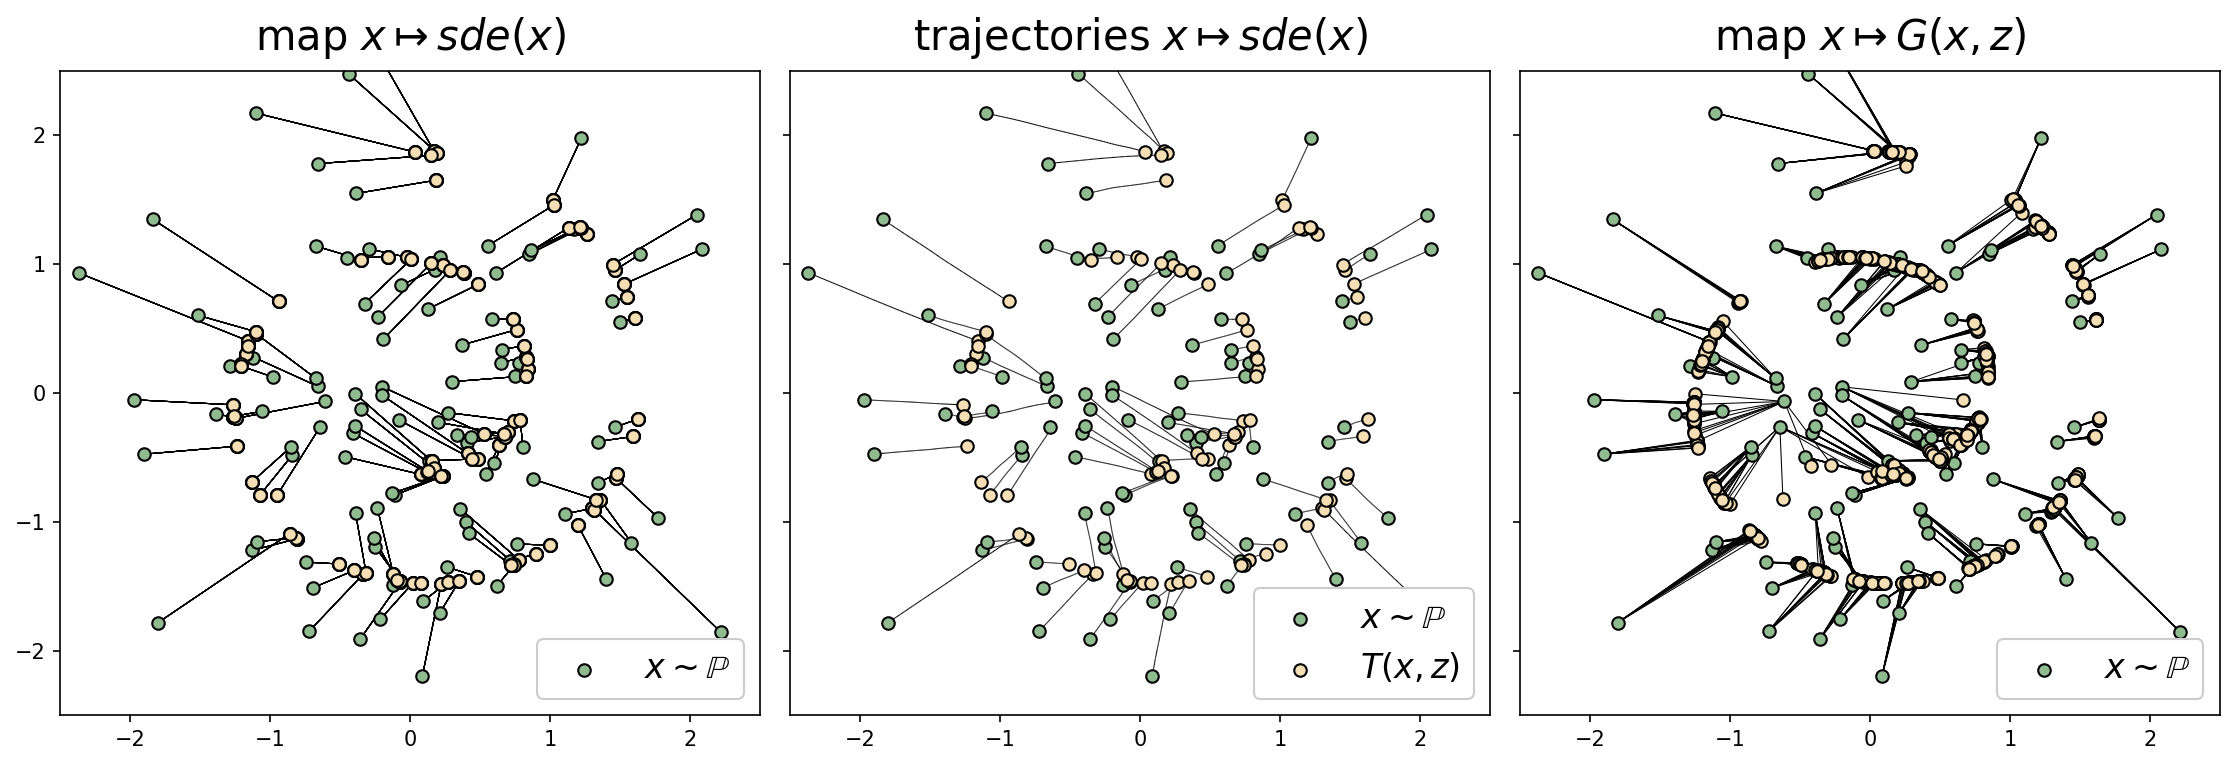

In [7]:
fig, axes = plot_trajectories(X_sampler, G, ZC, Z_STD, sde, k=10)
plt.show()